In [1]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from google.colab.files import upload

In [2]:
img1=upload()
img2=upload()

Saving img0.png to img0.png


Saving img1.png to img1.png


In [36]:
def stereo_match(left_img, right_img, kernel, max_offset):
  left_img = Image.open(left_img).convert('L')
  left = np.asarray(left_img)
  right_img = Image.open(right_img).convert('L')
  right = np.asarray(right_img)    
  w, h = left_img.size  
  depth = np.zeros((w, h))
  depth.shape = h, w    
  kernel_half = int(kernel / 2)    
  offset_adjust = 255 / max_offset      
  for y in range(kernel_half, h - kernel_half):      
    print(".", end="", flush=True)       
    for x in range(kernel_half, w - kernel_half):
      best_offset = 0
      prev_ssd = 65534
      for offset in range(max_offset):               
        ssd = 0
        ssd_temp = 0                            
        for v in range(-kernel_half, kernel_half):
          for u in range(-kernel_half, kernel_half):
            ssd_temp = int(left[y+v, x+u]) - int(right[y+v, (x+u) - offset])  
            ssd += ssd_temp * ssd_temp              
        if ssd < prev_ssd:
          prev_ssd = ssd
          best_offset = offset
      depth[y, x] = best_offset * offset_adjust
  return depth

............................................................................................................................................................................................................................................................................................................................................................

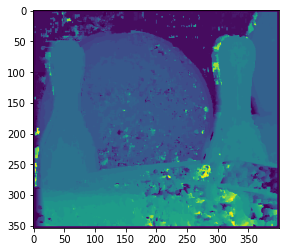

In [37]:
depth=stereo_match("img0.png", "img1.png", 6, 30)
imshow(depth)

In [ ]:
#!/usr/bin/env python
# --------------------------------------------------------------------
# Simple sum of squared differences (SSD) stereo-matching using Numpy
# --------------------------------------------------------------------

# Copyright (c) 2016 David Christian
# Licensed under the MIT License
import numpy as np
from PIL import Image

def stereo_match(left_img, right_img, kernel, max_offset):
    # Load in both images, assumed to be RGBA 8bit per channel images
    left_img = Image.open(left_img).convert('L')
    left = np.asarray(left_img)
    right_img = Image.open(right_img).convert('L')
    right = np.asarray(right_img)    
    w, h = left_img.size  # assume that both images are same size   
    
    # Depth (or disparity) map
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
       
    kernel_half = int(kernel / 2)    
    offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range
      
    for y in range(kernel_half, h - kernel_half):      
        print(".", end="", flush=True)  # let the user know that something is happening (slowly!)
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ssd = 65534
            
            for offset in range(max_offset):               
                ssd = 0
                ssd_temp = 0                            
                
                # v and u are the x,y of our local window search, used to ensure a good 
                # match- going by the squared differences of two pixels alone is insufficient, 
                # we want to go by the squared differences of the neighbouring pixels too
                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        # iteratively sum the sum of squared differences value for this block
                        # left[] and right[] are arrays of uint8, so converting them to int saves
                        # potential overflow, and executes a lot faster 
                        ssd_temp = int(left[y+v, x+u]) - int(right[y+v, (x+u) - offset])  
                        ssd += ssd_temp * ssd_temp              
                
                # if this value is smaller than the previous ssd at this block
                # then it's theoretically a closer match. Store this value against
                # this block..
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset
                            
            # set depth output for this x,y location to the best match
            depth[y, x] = best_offset * offset_adjust
                                
    # Convert to PIL and save it
    Image.fromarray(depth).save('depth.png')

if __name__ == '__main__':
    stereo_match("view0.png", "view1.png", 6, 30)  # 6x6 local search kernel, 30 pixel search range
